In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                        roc_curve, auc, roc_auc_score, log_loss)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score


In [13]:
data_path = '/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/sheep/extracted_data/3s.csv'
features = pd.read_csv(data_path)
features.drop(columns=['center_time', 'start_time', 'end_time', 'start_idx', 'end_idx'], inplace=True)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(features['label'])

features['label'] = labels

X = features.drop(columns=['experiment_id', 'label'])
y = features['label']
groups = features['experiment_id']

In [14]:
def generate_accuracy_and_heatmap(model, X, y):
    y_pred = model.predict(X)
    
    # Define class order with 'void' first (even though it's encoded as 1)
    # classes_ordered = ['void', 'non-void']  # Display order you want
    # labels_ordered = [1, 0]  # Corresponding encoded values
    
    classes_ordered = ['pre-void','void', 'post-void']  # Display order you want
    labels_ordered = [1, 2, 0]  # Corresponding encoded values
    
    ac = accuracy_score(y, y_pred)
    # f_score = f1_score(y, y_pred, average='macro', pos_label=1)  # void as positive
    f_score = f1_score(y, y_pred, average='macro', pos_label=2)  # void as positive
    
    print("Accuracy is: ", ac)
    print("F1 Score is: ", f_score)
    print('\n')
    
    # Crosstab
    print(pd.crosstab(pd.Series(y_pred, name='Predicted'), 
                    pd.Series(y, name='Actual')))
    print('\n')
    
    # Confusion matrix with void on top
    cm = confusion_matrix(y, y_pred, labels=labels_ordered)  # [1, 0] order
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=classes_ordered)  # ['void', 'non-void']
    cm_display.plot()
    plt.show()
    
    # Classification report with void first
    report = classification_report(y, y_pred, 
                                labels=labels_ordered,  # [1, 0]
                                target_names=classes_ordered)  # ['void', 'non-void']
    print("Classification Report:")
    print(report)
    
    return y_pred

In [15]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = XGBClassifier(eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy is:  0.5023696682464455
F1 Score is:  0.47681948665991225


Actual     0  1   2
Predicted          
0          2  5   6
1          3  0   3
2          5  1  12




/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1784: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


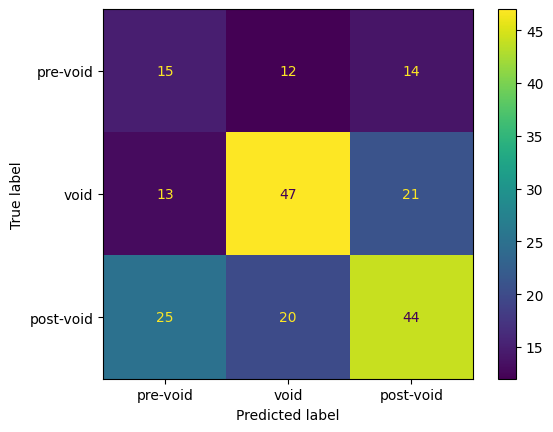

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.28      0.37      0.32        41
        void       0.59      0.58      0.59        81
   post-void       0.56      0.49      0.52        89

    accuracy                           0.50       211
   macro avg       0.48      0.48      0.48       211
weighted avg       0.52      0.50      0.51       211



In [17]:
y_pred = generate_accuracy_and_heatmap(model, X_test, y_test)

In [26]:
from sklearn.metrics import cohen_kappa_score

# Simple calculation
# kappa = cohen_kappa_score(y_test, y_pred)
# print(kappa)

# For your specific case:
def calculate_kappa_with_details(y_true, y_pred):
    kappa = cohen_kappa_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"Kappa: {kappa:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    
    # Interpretation (Landis & Koch 1977 - cited in the paper)
    if kappa < 0:
        interpretation = "Poor (less than chance agreement)"
    elif kappa < 0.20:
        interpretation = "Slight"
    elif kappa < 0.40:
        interpretation = "Fair"
    elif kappa < 0.60:
        interpretation = "Moderate" 
    elif kappa < 0.80:
        interpretation = "Substantial"
    else:
        interpretation = "Almost Perfect"
    
    print(f"Interpretation: {interpretation}")
    return 
calculate_kappa_with_details(y_test, y_pred)

Kappa: 0.234
Accuracy: 0.502
Interpretation: Fair


In [19]:
select_feature = SelectKBest(f_classif, k=5).fit(X_train, y_train)

/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14 15] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [20]:
# # Ensure full display
# pd.set_option("display.max_rows", None)   # Show all rows
# pd.set_option("display.max_columns", None)  # Show all columns
# pd.set_option("display.width", None)    # No wrapping
# pd.set_option("display.max_colwidth", None)  # Show long column values


selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                    'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
34,sd_gyr_y,43.558814
6,min_st_x,41.385555
35,sd_gyr_z,36.161814
3,sd_st_x,35.382306
37,min_gyr_y,34.781473
41,max_gyr_z,32.739788
38,min_gyr_z,29.186052
40,max_gyr_y,27.543338
39,max_gyr_x,27.375240
20,mean_vedba_s,24.122846


In [21]:
X_train_selected = select_feature.transform(X_train)
X_test_selected = select_feature.transform(X_test)

In [22]:
model.fit(X_train_selected, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy is:  0.44549763033175355
F1 Score is:  0.41896721165013845


Actual     0  1   2
Predicted          
0          1  1   5
1          3  0   3
2          6  5  13




/home/edumaba/Public/MPhil_Thesis/Code/wear_uropatch/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1784: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


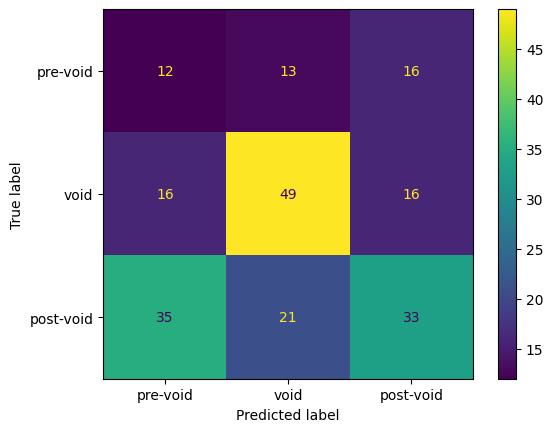

Classification Report:
              precision    recall  f1-score   support

    pre-void       0.19      0.29      0.23        41
        void       0.59      0.60      0.60        81
   post-void       0.51      0.37      0.43        89

    accuracy                           0.45       211
   macro avg       0.43      0.42      0.42       211
weighted avg       0.48      0.45      0.46       211



array([1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 0, 2, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2, 0,
       0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0])

In [23]:
generate_accuracy_and_heatmap(model, X_test_selected, y_test)